In [1]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.pipeline import make_pipeline

import warnings

today = dt.date.today()
this_month = pd.to_datetime(str(today.year)+'-'+str(today.month)+'-01')

%matplotlib inline

%qtconsole

In [2]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\processed\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

In [3]:
df = pd.read_csv(data_processed_dir+'processed_data.csv')
df.date = pd.to_datetime(df.date)
df = df.sort_values(by='date', ascending=True)
df = df[df.date > '2016-06'].reset_index(drop=True)
df.head(2)

,date,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,usa_net_import_smooth,usa_net_import,usa_stocks_all,usa_l48_prod_smooth,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
0,2016-06-03,325.0,31.322,36.822,49.000,48.905,7.1945,7.216,1196.948,8.248,...,36.893488,32.772432,1.041334,60.121197,36.822,46.583235,36.822,49.971020,36.822,96.554255
1,2016-06-10,328.0,34.434,36.720,50.184,49.944,7.1560,7.133,1196.015,8.224,...,36.940973,32.761824,1.011001,60.325617,36.720,46.580276,36.720,49.813063,36.720,96.393339


In [4]:
# Remove wti_spot, brent_spot for redundant values with wti_spot_lag_14
#df = df.drop(['brent_spot'],axis=1)

# Noticed significant variation in early models that were not present in the majority of the data. 
# SelectKBest ended up adding much more significance to the world_cons data and caused modeling
# issues with MinMaxScaler... Same issues existed with StandardScaler

#df = df.drop(['world_cons','oecd_cons','non-oecd_cons','usa_net_import','usa_l48_prod'],axis=1)
df.head(2)

,date,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,usa_net_import_smooth,usa_net_import,usa_stocks_all,usa_l48_prod_smooth,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
0,2016-06-03,325.0,31.322,36.822,49.000,48.905,7.1945,7.216,1196.948,8.248,...,36.893488,32.772432,1.041334,60.121197,36.822,46.583235,36.822,49.971020,36.822,96.554255
1,2016-06-10,328.0,34.434,36.720,50.184,49.944,7.1560,7.133,1196.015,8.224,...,36.940973,32.761824,1.011001,60.325617,36.720,46.580276,36.720,49.813063,36.720,96.393339


In [5]:
df.shape

(222, 21)

## Train Test Split
Define features X, and target variable y

In [6]:
X = df.iloc[:,2:]
y = df.iloc[:,1]

date = df.date

model_score = pd.DataFrame(columns=['model','rmse','r2','mae'])

#scaler = MinMaxScaler()
#scaler.fit(df.iloc[:,1:])
#X = scaler.transform(df.iloc[:,1:])
#X = pd.DataFrame(X,columns=df.iloc[:,1:].columns)
#X[['Total US RigCount','wti_spot_lag_14']].plot(figsize=(12,10))

In [7]:
# Define functions
def plot_model(date,X,y,ts_cv,pipe,plot=True):

    mse = []
    r2 = []
    mae = []
    
    if plot == True:
        fig, ax = plt.subplots(figsize=(18,10))
        ax.plot(date,y)
        ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
        plt.xticks(rotation=75)

        for ii, (tr, tt) in enumerate(ts_cv.split(X,y)):
            X_tr = X.iloc[tr,:]
            y_tr = y.iloc[tr]
            X_tt = X.iloc[tt,:]
            y_tt = y.iloc[tt]
            pipe.fit(X_tr,y_tr)

            y_pred = pipe.predict(X_tt)

            mse.append(mean_squared_error(y_pred,y_tt,squared=False))
            r2.append(r2_score(y_pred,y_tt))
            mae.append(mean_absolute_error(y_pred,y_tt))

            ax.plot(date[tt],y_pred, label='test iter no '+str(ii+1))
        
        plt.legend()
        plt.show()

    else:
        
        for ii, (tr, tt) in enumerate(ts_cv.split(X,y)):
            X_tr = X.iloc[tr,:]
            y_tr = y.iloc[tr]
            X_tt = X.iloc[tt,:]
            y_tt = y.iloc[tt]
            pipe.fit(X_tr,y_tr)

            y_pred = pipe.predict(X_tt)

            mse.append(mean_squared_error(y_pred,y_tt,squared=False))
            r2.append(r2_score(y_pred,y_tt))
            mae.append(mean_absolute_error(y_pred,y_tt))
            
    return np.mean(mse), np.mean(r2), np.mean(mae)

def add_model(model, errors):
    
    global model_score
    
    rmse, r2, mae = errors
    
    row = {
        'model':model,
        'rmse':rmse,
        'r2':r2,
        'mae':mae 
    }
    
    model_score = model_score.append(row,ignore_index=True)
    
    return errors

### Linear Regression 
Baseline model will be a linear regression with all features.

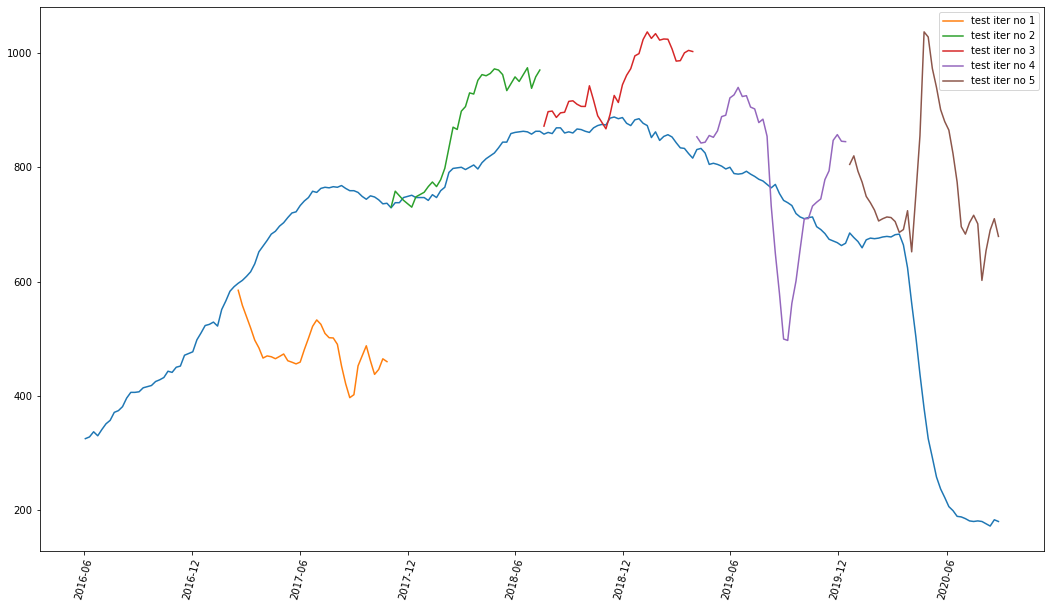

(199.40862915532648, -11.844447059872735, 168.84156005702386)

In [8]:
# Baseline linear regression with no additional features
n_splits = 5

model = LinearRegression()
cv = TimeSeriesSplit(n_splits=n_splits)
pipe = make_pipeline(model)

lin_base = plot_model(date,X,y,cv,pipe)
add_model('linear_base',lin_base)

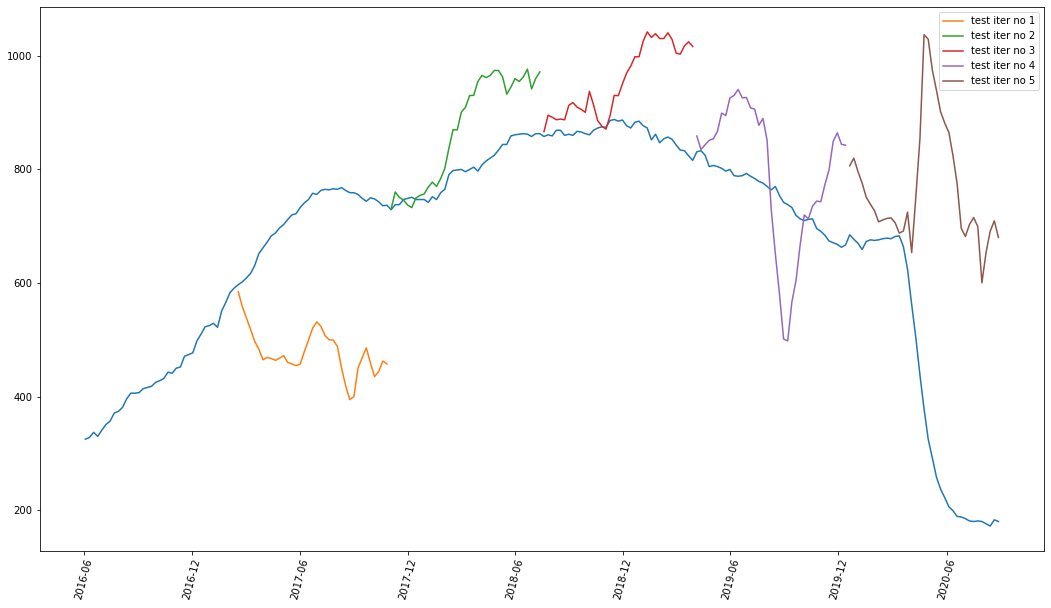

(201.6101056537917, -11.728909028945084, 170.612551997859)

In [9]:
# Add scaler to features
scaler = StandardScaler()
pipe = make_pipeline(scaler,model)

lin_scal = plot_model(date,X,y,cv,pipe)
add_model('linear_scaled',lin_scal)

In [10]:
# Let's try with rolling window for the time series to account for the data being non-stationary

max_train_score = pd.DataFrame(columns=['rmse','r2','mae'])

warnings.filterwarnings('ignore')  

for i in np.arange(1,df.shape[0]):
    cv = TimeSeriesSplit(n_splits=n_splits,max_train_size=i)

    mse, r2, mae = plot_model(date,X,y,cv,pipe,plot=False)
    
    max_train_score.loc[i,'rmse'] = mse
    max_train_score.loc[i,'r2'] = r2
    max_train_score.loc[i,'mae'] = mae

warnings.filterwarnings('default')  
    
max_train_score.sort_values(by='rmse', inplace=True)
max_train_score.head()

,rmse,r2,mae
6,89.3373,-4.8705,70.4149
7,102.357,-2.75474,81.792
5,103.444,-5.36523,78.7256
8,103.852,-2.07642,84.2476
4,111.166,-18.8593,90.6241


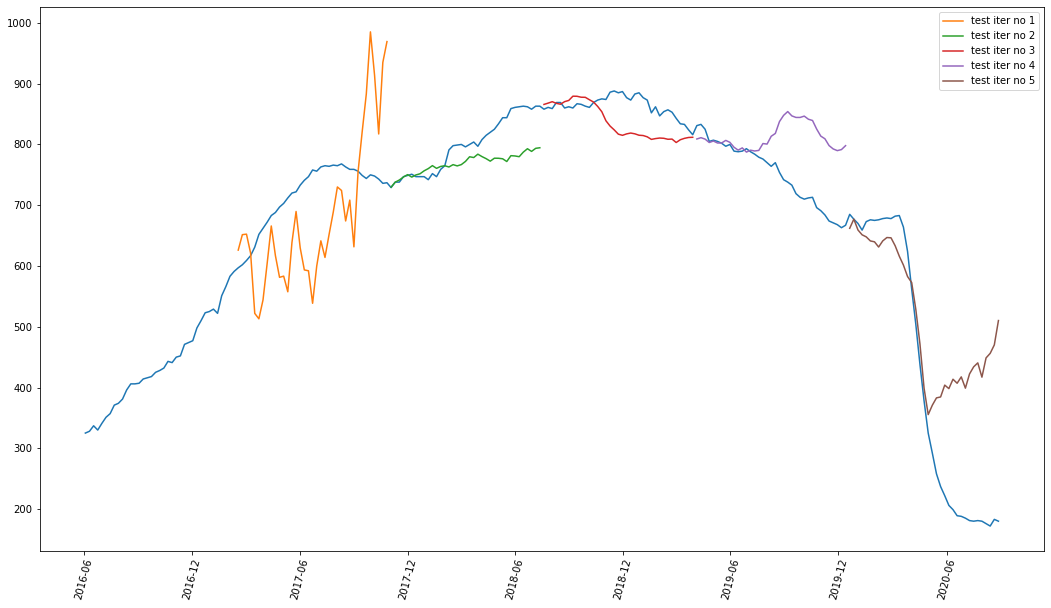

(89.33727192969307, -4.87050285864572, 70.41485999483696)

In [11]:
# Use 112 as the others are too small
max_train_best = max_train_score.index[0]

cv = TimeSeriesSplit(n_splits=n_splits,max_train_size=max_train_best)

plot_model(date,X,y,cv,pipe)

In [12]:
# Parameter tuning for SelectKBest - manual
k_score = pd.DataFrame(columns=['k','rmse','r2','mae'])

warnings.filterwarnings('ignore')  

for i in np.arange(1,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    pipe = make_pipeline(scaler,feat_sel,model)
  
    mse, r2, mae = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'k':i,
        'rmse':mse,
        'r2':r2,
        'mae':mae
    }
        
    k_score = k_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')  
    
k_score.sort_values(by='rmse',inplace=True)
k_score.head()

,k,rmse,r2,mae
16,17.0,80.867908,-5.065658,67.061380
0,1.0,83.501173,-20.445936,67.029043
17,18.0,87.480634,-5.347393,70.455817
18,19.0,89.337272,-4.870503,70.414860
15,16.0,92.986151,-3.287008,76.410176


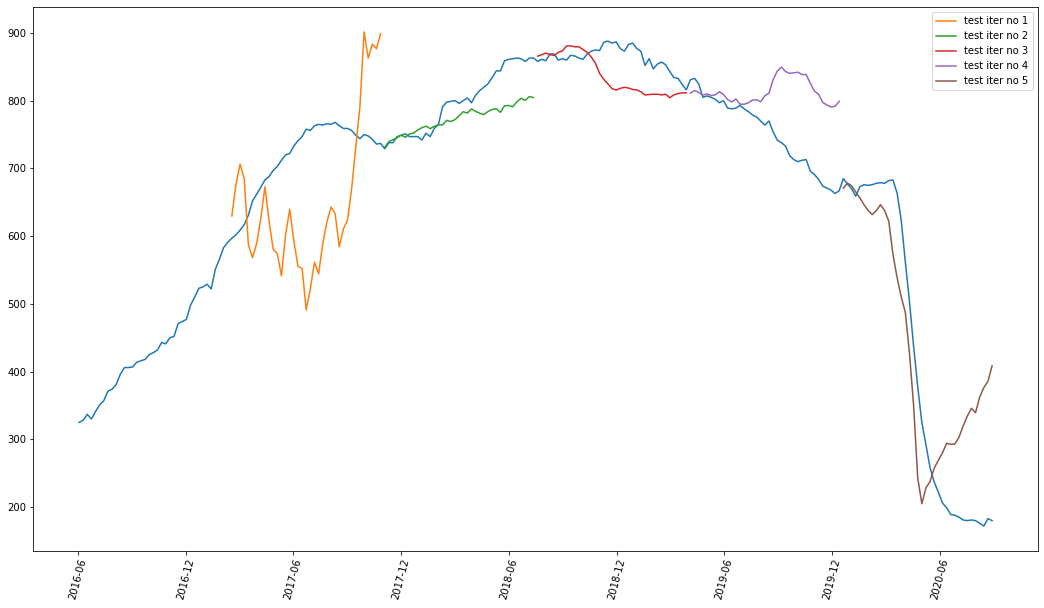

(80.867908208856, -5.065658455267086, 67.06138026436572)

In [13]:
k_best = int(k_score.k[k_score.index[0]])

feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

lin_kbest = plot_model(date,X,y,cv,pipe)
add_model('linear_kbest',lin_kbest)

In [14]:
pd.Series(model.coef_, index=X.columns[feat_sel.get_support()]).sort_values(ascending=False)

non-opec_tot_prod        2.534013
wti_spot                 2.285021
wti_spot_lag_14          1.081197
opec_tot_prod            0.312915
oecd_cons                0.202661
non-oecd_cons_smooth     0.184258
oecd_cons_smooth         0.184258
world_cons_smooth        0.184258
wti_spot_lag_9           0.184258
brent_spot              -0.124693
world_cons              -0.409179
usa_stocks_all          -0.428810
usa_net_import_smooth   -0.488281
non-oecd_cons           -0.700734
opec_surp_capac         -1.895144
opec_crud_capac         -2.131083
usa_l48_prod_smooth     -2.236730
dtype: float64

In [15]:
# Parameter tuning for linear regression - GridSearchCV
#feat_sel = SelectKBest(f_regression,k='all')
#pipe = make_pipeline(scaler,feat_sel,model)

#param_grid = {'selectkbest__k':np.arange(1,X.shape[1]+1)}

#gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=5,n_jobs=-1)

#plot_model(date,X,y,cv,gs_cv)

In [16]:
#selected = gs_cv.best_estimator_.named_steps.selectkbest.get_support()
#coefs = gs_cv.best_estimator_.named_steps.linearregression.coef_
#features = pd.Series(coefs, index=X.columns[selected]).sort_values(ascending=False)

#print(gs_cv.best_params_)
#print(features)

### Ridge Regression 
Baseline model will be a ridge regression with default alpha.

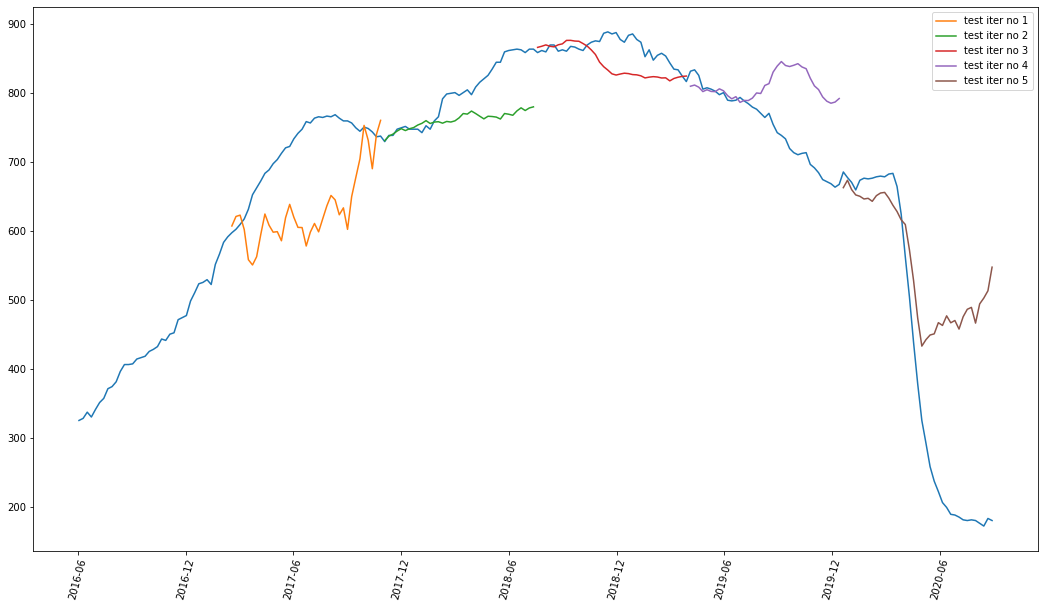

(92.73591469431278, -9.010097909311757, 72.99682316270176)

In [17]:
model = Ridge()
pipe = make_pipeline(scaler,model)

ridge_base = plot_model(date,X,y,cv,pipe)
add_model('ridge_base',ridge_base)

In [18]:
alpha_score = pd.DataFrame(columns=['alpha','rmse','r2','mae'])

warnings.filterwarnings('ignore')

for j in np.arange(0.001,0.5,step=0.005):
    model = Ridge(alpha=j)
    pipe = make_pipeline(scaler,model)
  
    mse, r2, mae = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'alpha':j,
        'rmse':mse,
        'r2':r2,
        'mae':mae
    }
        
    alpha_score = alpha_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')  
    
alpha_score.sort_values(by='rmse',inplace=True)
alpha_score.head()

,alpha,rmse,r2,mae
38,0.191,88.110975,-5.523377,69.953009
37,0.186,88.111364,-5.505345,69.956369
39,0.196,88.111719,-5.541458,69.949935
36,0.181,88.112918,-5.487362,69.960021
40,0.201,88.113562,-5.559588,69.947141


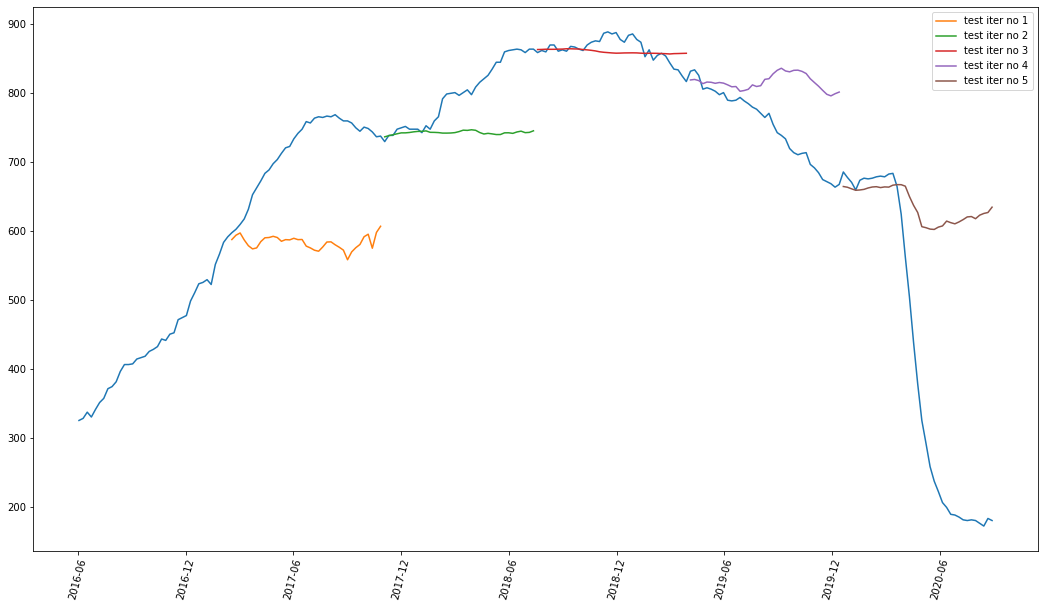

(121.64212202411063, -310.8014751369259, 98.24794947343233)

In [19]:
alpha_best = alpha_score.index[0]
model = Ridge(alpha=alpha_best)
pipe = make_pipeline(scaler,model)

ridge_alpha = plot_model(date,X,y,cv,pipe)
add_model('ridge_alpha',ridge_alpha)

In [20]:
ak_score = pd.DataFrame(columns=['k','alpha','rmse','r2','mae'])

warnings.filterwarnings('ignore')

for i in range(2,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for j in np.arange(0.1,0.5,step=0.001):
        model = Ridge(alpha=j)
        pipe = make_pipeline(scaler,feat_sel,model)
  
        mse, r2, mae = plot_model(date,X,y,cv,pipe,plot=False)
        
        new_row = {
            'k':i,
            'alpha':j,
            'rmse':mse,
            'r2':r2,
            'mae':mae
        }
        
        ak_score = ak_score.append(new_row,ignore_index=True)
        
warnings.filterwarnings('default')    

ak_score.sort_values(by='rmse',inplace=True)
ak_score.head()

,k,alpha,rmse,r2,mae
4895,14.0,0.195,70.287075,-2.859838,53.401869
4896,14.0,0.196,70.287491,-2.860613,53.412039
4894,14.0,0.194,70.287626,-2.859088,53.391647
4897,14.0,0.197,70.288858,-2.861413,53.426044
4893,14.0,0.193,70.289160,-2.858363,53.381371


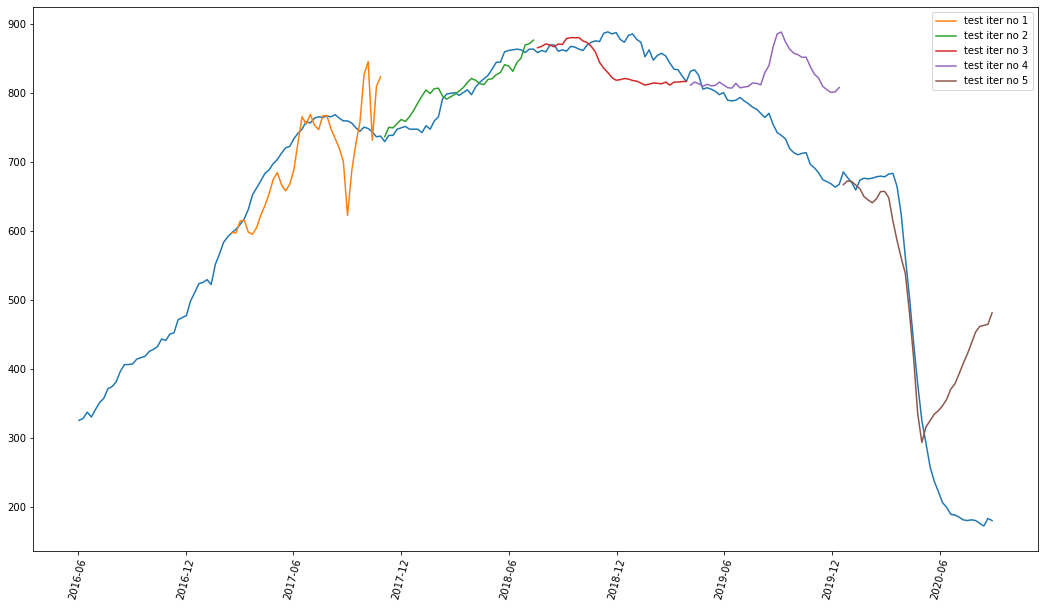

(70.28707517025518, -2.8598381712927146, 53.40186928279081)

In [21]:
alpha_best = ak_score.alpha[ak_score.index[0]]
k_best = int(ak_score.k[ak_score.index[0]])

model = Ridge(alpha=alpha_best)
feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

ridge_ak = plot_model(date,X,y,cv,pipe)
add_model('ridge_ak',ridge_ak)

In [22]:
print(pd.Series(model.coef_, index=X.columns[feat_sel.get_support()]).sort_values(ascending=False))

non-opec_tot_prod        2.676444
wti_spot                 1.415159
world_cons_smooth        0.413724
non-oecd_cons_smooth     0.413724
usa_stocks_all           0.307208
opec_tot_prod            0.120902
brent_spot               0.012503
oecd_cons               -0.002316
world_cons              -0.681235
non-oecd_cons           -1.001814
opec_surp_capac         -1.922641
usa_net_import_smooth   -2.063582
opec_crud_capac         -2.198334
usa_l48_prod_smooth     -2.269899
dtype: float64


### Lasso Regression 
Baseline model will be a lasso regression with no alpha optimisation.

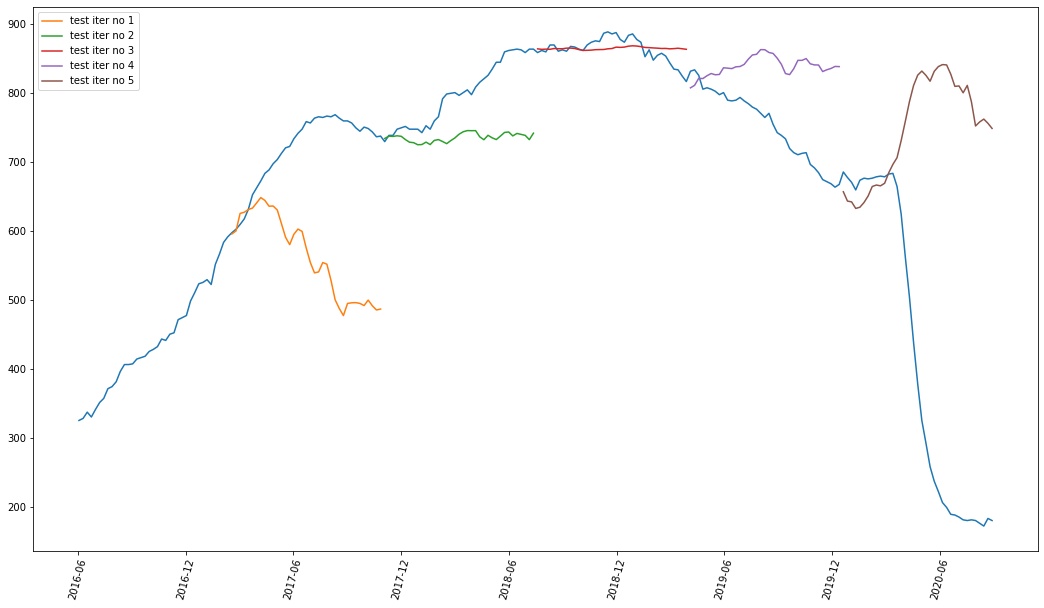

(162.0551579352384, -73.82430789406068, 130.96789287437662)

In [23]:
model = Lasso()
pipe = make_pipeline(scaler,model)

lasso_base = plot_model(date,X,y,cv,model)
add_model('lasso_base',lasso_base)

In [24]:
alpha_score = pd.DataFrame(columns=['alpha','rmse','r2','mae'])

for j in np.arange(0.75,2,step=0.005):
    model = Lasso(alpha=j)
    pipe = make_pipeline(scaler,model)
  
    mse, r2, mae = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'alpha':j,
        'rmse':mse,
        'r2':r2,
        'mae':mae
    }

    alpha_score = alpha_score.append(new_row,ignore_index=True)
    
alpha_score.sort_values(by='rmse',inplace=True)
alpha_score.head()

,alpha,rmse,r2,mae
75,1.125,69.584749,-4.509152e+27,55.427347
74,1.120,69.585482,-2.144280e+05,55.409681
76,1.130,69.586040,-4.509152e+27,55.446720
73,1.115,69.586068,-1.498930e+04,55.391820
77,1.135,69.586751,-4.509152e+27,55.465207


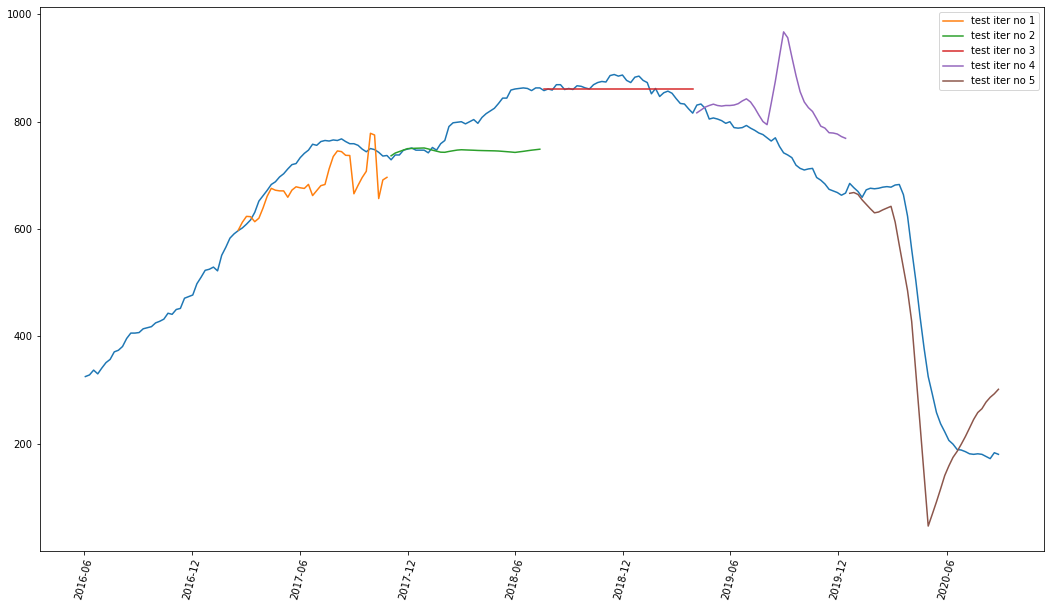

(69.58474891353372, -4.509152447337337e+27, 55.42734749349154)

In [25]:
alpha_best = alpha_score.alpha[alpha_score.index[0]]
model = Lasso(alpha=alpha_best)
pipe = make_pipeline(scaler,model)

lasso_alpha = plot_model(date,X,y,cv,pipe)
add_model('lasso_alpha',lasso_alpha)

In [26]:
ak_score = pd.DataFrame(columns=['k','alpha','rmse','r2','mae'])

warnings.filterwarnings('ignore')

for i in range(1,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for j in np.arange(0.5,1,step=0.005):
        model = Lasso(alpha=j)
        pipe = make_pipeline(scaler,feat_sel,model)
  
        mse, r2, mae = plot_model(date,X,y,cv,pipe,plot=False)
        
        new_row = {
            'k':i,
            'alpha':j,
            'rmse':mse,
            'r2':r2,
            'mae':mae
        }
        
        ak_score = ak_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')    
    
ak_score.sort_values(by='rmse',inplace=True)
ak_score.head()

,k,alpha,rmse,r2,mae
753,8.0,0.765,59.500900,-105.820662,47.204491
1053,11.0,0.765,59.500924,-105.823468,47.204460
953,10.0,0.765,59.501089,-105.822766,47.204635
853,9.0,0.765,59.501089,-105.822766,47.204635
1052,11.0,0.760,59.532830,-105.392873,47.218384


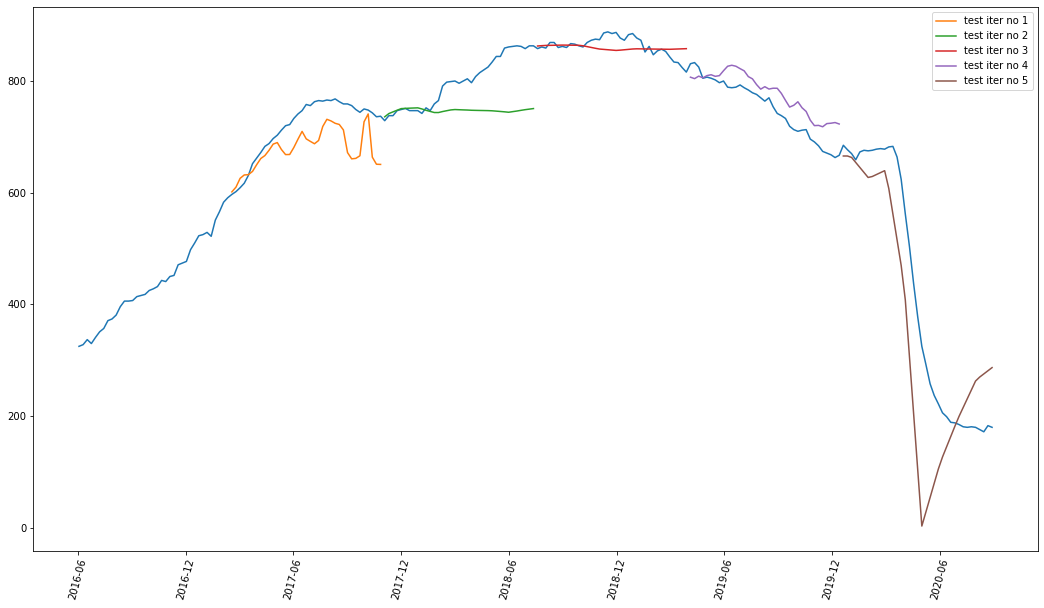

(59.500900338395034, -105.82066190600634, 47.20449072674021)

In [27]:
alpha_best = ak_score.alpha[ak_score.index[0]]
k_best = int(ak_score.k[ak_score.index[0]])

model = Lasso(alpha=alpha_best)
feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

lasso_ak = plot_model(date,X,y,cv,pipe)
add_model('lasso_ak',lasso_ak)

In [28]:
print(pd.Series(model.coef_, index=X.columns[feat_sel.get_support()]).sort_values(ascending=False))

non-opec_tot_prod      5.613258
opec_surp_capac       -0.000000
opec_crud_capac       -0.000000
opec_tot_prod          0.000000
usa_l48_prod_smooth   -0.000000
usa_stocks_all         0.000000
brent_spot            -0.000000
wti_spot               0.000000
dtype: float64


### ElasticNet Regression 
Baseline model will be a default ElasticNet regression

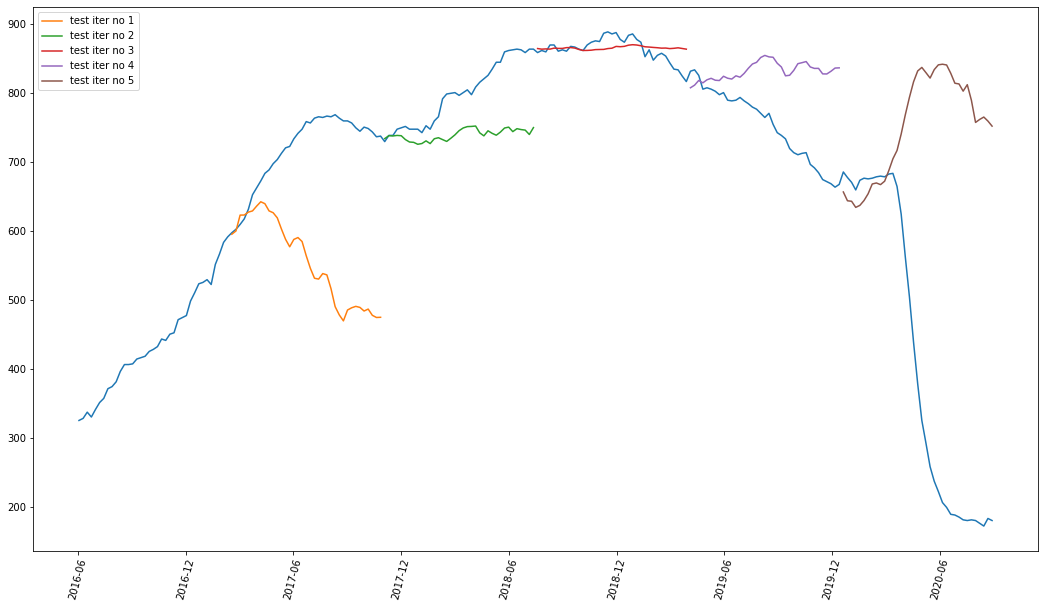

(162.26773857919278, -50.71614596647978, 130.81466582523845)

In [29]:
model = ElasticNet()
pipe = make_pipeline(scaler,model)

elastic_base = plot_model(date,X,y,cv,model)
add_model('elastic_base',elastic_base)

In [30]:
alpha_score = pd.DataFrame(columns=['alpha','rmse','r2','mae'])

warnings.filterwarnings('ignore')

for j in np.arange(0.01,0.75,step=0.001):
    model = ElasticNet(alpha=j)
    pipe = make_pipeline(scaler,model)
  
    mse, r2, mae = plot_model(date,X,y,cv,pipe,plot=False)
        
    new_row = {
        'alpha':j,
        'rmse':mse,
        'r2':r2,
        'mae':mae
    }

    alpha_score = alpha_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')   
    
alpha_score.sort_values(by='rmse',inplace=True)
alpha_score.head()

,alpha,rmse,r2,mae
7,0.017,88.152547,-6.908908,69.807179
8,0.018,88.274566,-6.696885,69.891852
6,0.016,88.382343,-6.886218,70.103672
9,0.019,88.675714,-6.326793,70.285160
5,0.015,88.809003,-6.764070,70.619169


C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.442167186671497, tolerance: 0.39580000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03221232404897896, tolerance: 0.016
  model = cd_fast.enet_coordinate_descent(
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18965143989841185, tolerance: 0.08668333333333335
  model = cd_fast.enet_coordinate_descent(


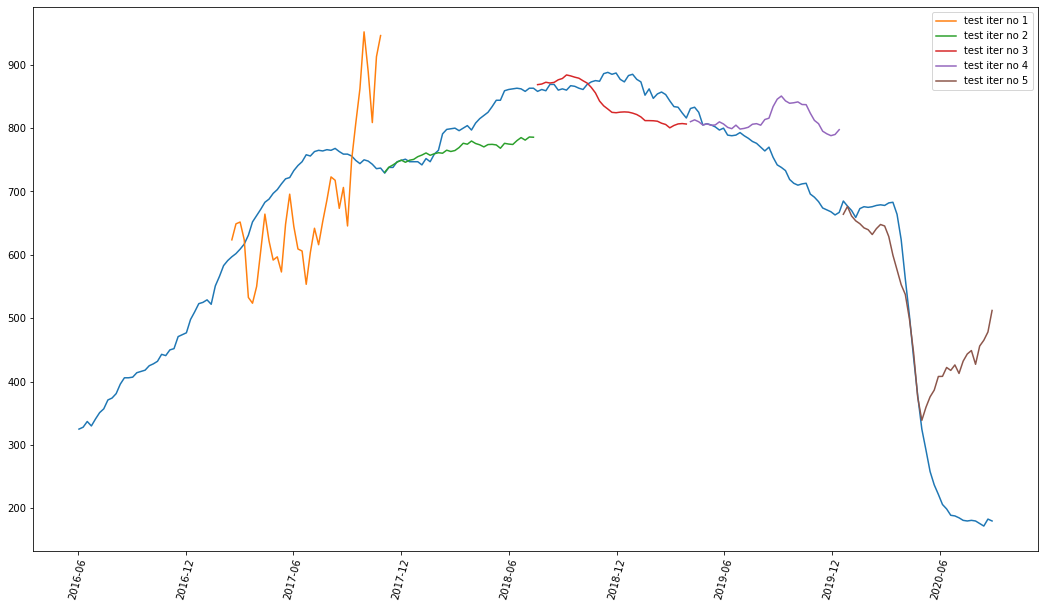

(88.15254704001424, -6.9089084686789395, 69.8071792570618)

In [31]:
alpha_best = alpha_score.alpha[alpha_score.index[0]]
model = ElasticNet(alpha=alpha_best)
pipe = make_pipeline(scaler,model)

elastic_alpha = plot_model(date,X,y,cv,pipe)
add_model('elastic_alpha',elastic_alpha)

In [32]:
ak_score = pd.DataFrame(columns=['k','alpha','rmse','r2','mae'])

warnings.filterwarnings('ignore')

for i in range(2,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for j in np.arange(0.001,0.2,step=0.001):
        model = ElasticNet(alpha=j)
        pipe = make_pipeline(scaler,feat_sel,model)
  
        mse, r2, mae = plot_model(date,X,y,cv,pipe,plot=False)
        
        new_row = {
            'k':i,
            'alpha':j,
            'rmse':mse,
            'r2':r2,
            'mae':mae
        }
        
        ak_score = ak_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')    
    
ak_score.sort_values(by='rmse',inplace=True)
ak_score.head()

,k,alpha,rmse,r2,mae
2441,14.0,0.054,69.451194,-2.636239,53.235606
2442,14.0,0.055,69.454561,-2.641131,53.298166
2440,14.0,0.053,69.464075,-2.631807,53.172690
2443,14.0,0.056,69.472484,-2.646187,53.376451
2439,14.0,0.052,69.499440,-2.627983,53.122037


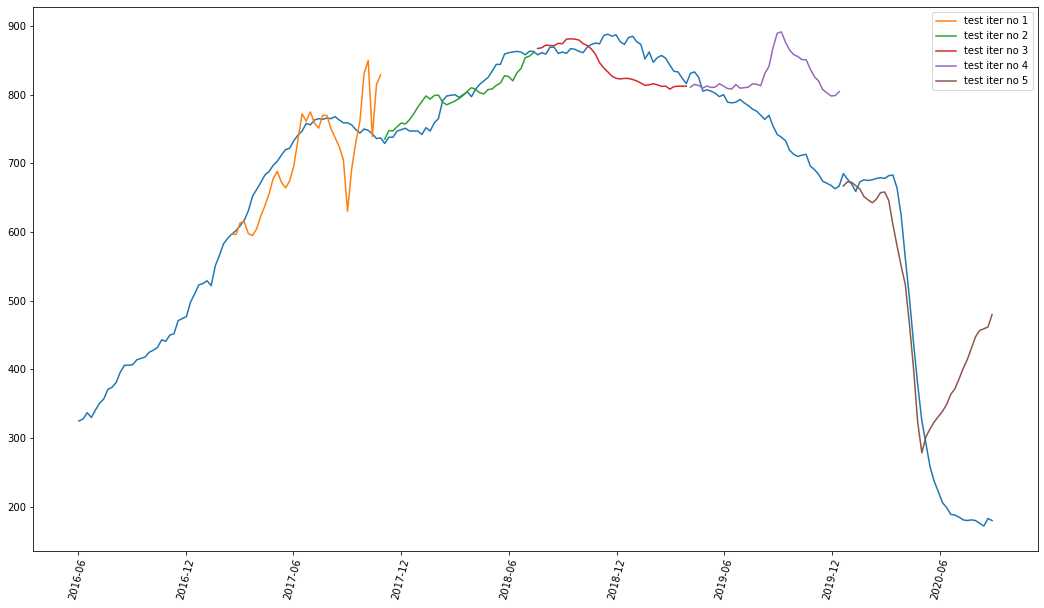

(69.4511936433021, -2.636238653793959, 53.23560621711001)

In [33]:
alpha_best = ak_score.alpha[ak_score.index[0]]
k_best = int(ak_score.k[ak_score.index[0]])

model = ElasticNet(alpha=alpha_best)
feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

elastic_ak = plot_model(date,X,y,cv,pipe)
add_model('elastic_ak',elastic_ak)

### Random Forest Regression 
Baseline model will be a default RF regression

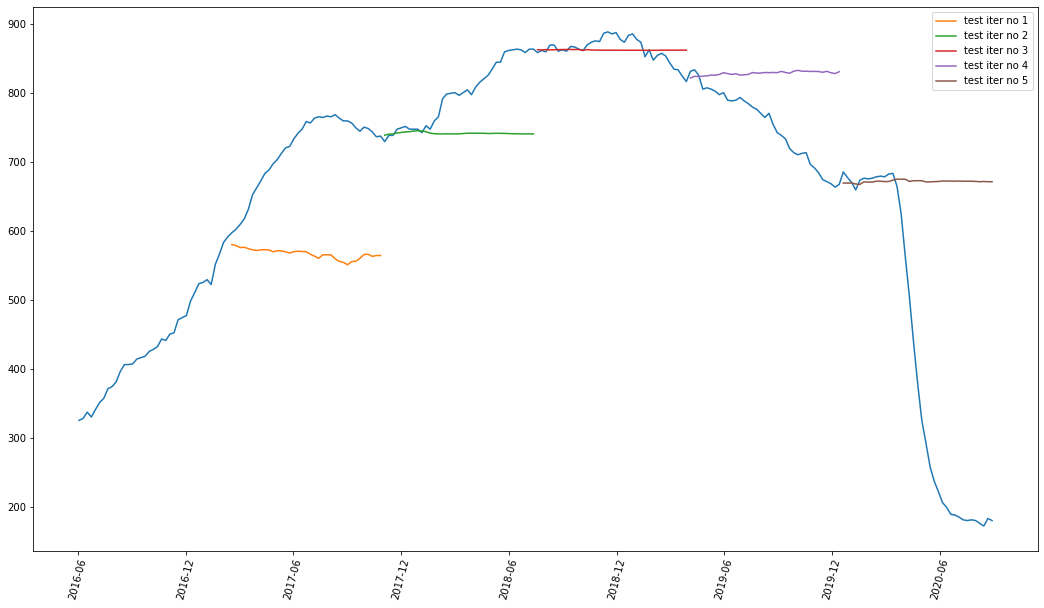

(135.32383710228868, -10119.104474247488, 109.93021621621622)

In [34]:
model = RandomForestRegressor(random_state=42)

pipe = make_pipeline(scaler,model)

rand_base = plot_model(date,X,y,cv,model)
add_model('rand_base',rand_base)

In [35]:
est_score = pd.DataFrame(columns=['n_estimators','rmse','r2','mae'])

for n in np.arange(1,100,step=1):
    model = RandomForestRegressor(n_estimators = n)
    pipe = make_pipeline(scaler,model)
  
    mse, r2, mae = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'n_estimators':n,
        'rmse':mse,
        'r2':r2,
        'mae':mae
    }
        
    est_score = est_score.append(new_row,ignore_index=True)
        
est_score.sort_values(by='rmse',inplace=True)
est_score.head()

,n_estimators,rmse,r2,mae
4,5.0,132.528066,-5672.940263,107.110270
14,15.0,132.957607,-4496.245711,107.574414
11,12.0,133.558848,-5421.108228,108.464414
12,13.0,133.799838,-6614.329426,108.393763
16,17.0,134.059335,-11798.624583,108.695072


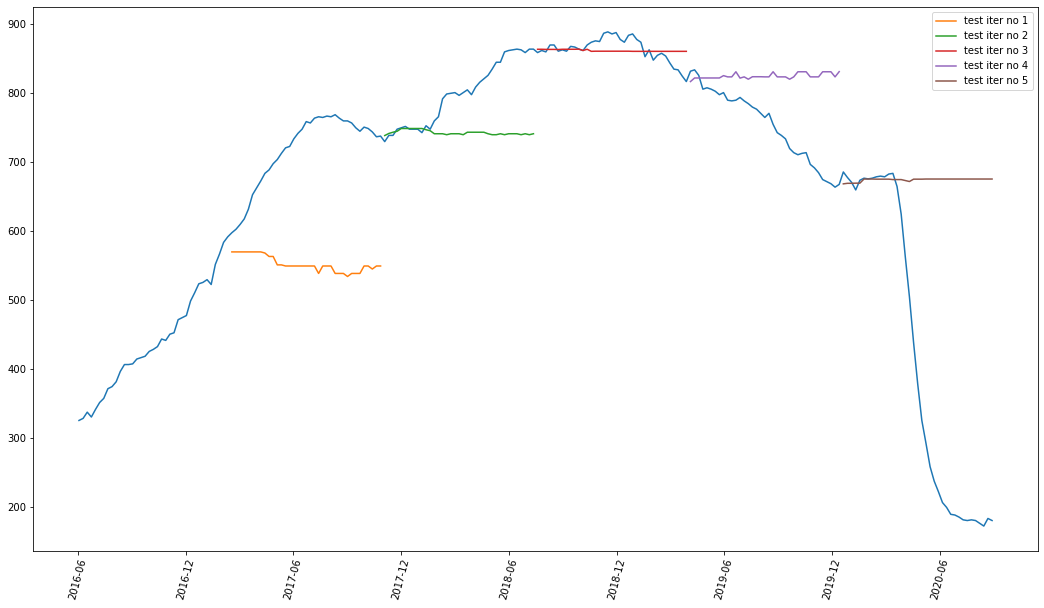

(138.30521619372547, -5114.342832199911, 112.31459459459458)

In [36]:
est_best = int(est_score.n_estimators[est_score.index[0]])

model = RandomForestRegressor(n_estimators = est_best)
pipe = make_pipeline(scaler,model)

rand_est = plot_model(date,X,y,cv,pipe)
add_model('rand_est',rand_est)

In [37]:
est_score = pd.DataFrame(columns=['k','n_estimate','rmse','r2','mae'])

warnings.filterwarnings('ignore')

for i in range(1,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for n in np.arange(1,100,step=1):
        model = RandomForestRegressor(n_estimators = n)
        pipe = make_pipeline(scaler,feat_sel,model)

        mse, r2, mae = plot_model(date,X,y,cv,pipe,plot=False)

        new_row = {
            'k':i,
            'n_estimate':n,
            'rmse':mse,
            'r2':r2,
            'mae':mae
        }

        est_score = est_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')    
    
est_score.sort_values(by='rmse',inplace=True)
est_score.head()

,k,n_estimate,rmse,r2,mae
0,1.0,1.0,129.177414,-8.362291e+01,104.837838
298,4.0,2.0,129.424647,-9.763304e+03,104.440541
26,1.0,27.0,130.136963,-1.674110e+30,105.575876
5,1.0,6.0,130.234565,-1.668700e+30,105.722523
94,1.0,95.0,130.323280,-1.339411e+02,105.831764


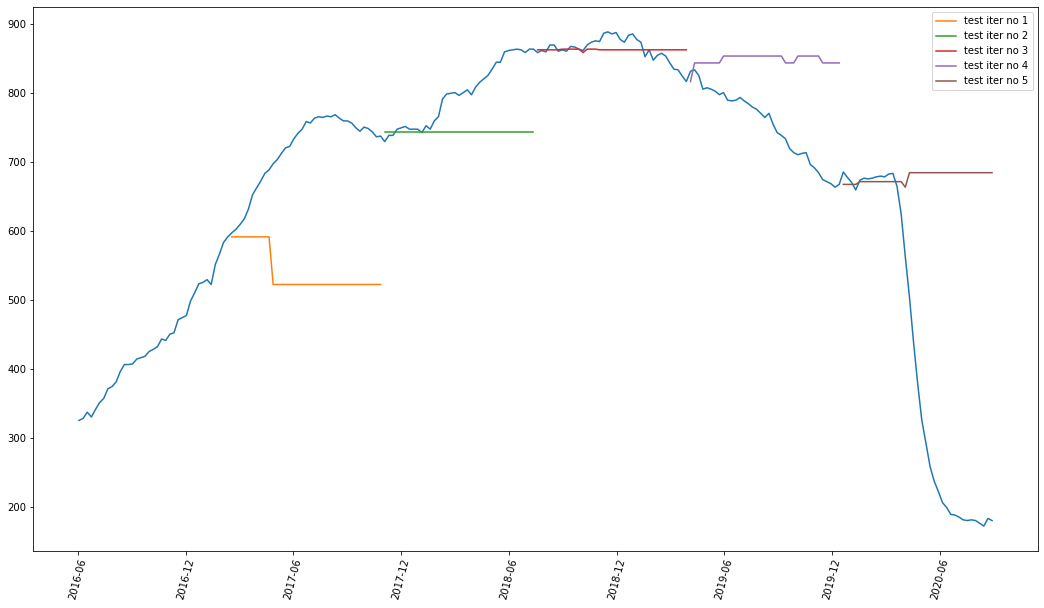

(146.6550868907369, -575.6377829449017, 120.1135135135135)

In [38]:
est_best = int(est_score.n_estimate[est_score.index[0]])

model = RandomForestRegressor(n_estimators = est_best)
pipe = make_pipeline(scaler,feat_sel,model)

rand_nk = plot_model(date,X,y,cv,pipe)
add_model('rand_nk',rand_nk)

In [40]:
model_score.sort_values(by='rmse')

,model,rmse,r2,mae
8,lasso_ak,59.500900,-1.058207e+02,47.204491
11,elastic_ak,69.451194,-2.636239e+00,53.235606
7,lasso_alpha,69.584749,-4.509152e+27,55.427347
5,ridge_ak,70.287075,-2.859838e+00,53.401869
2,linear_kbest,80.867908,-5.065658e+00,67.061380
10,elastic_alpha,88.152547,-6.908908e+00,69.807179
3,ridge_base,92.735915,-9.010098e+00,72.996823
4,ridge_alpha,121.642122,-3.108015e+02,98.247949
12,rand_base,135.323837,-1.011910e+04,109.930216
13,rand_est,138.305216,-5.114343e+03,112.314595
